In [66]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jun  9 20:45:06 2022

@author: Manasa Kesapragada, University of California, Santa Cruz

Program to:
 i) locate and track single cells
 ii) Extract speed, directedness and recruitment index measures

"""


'\nCreated on Thu Jun  9 20:45:06 2022\n\n@author: Manasa Kesapragada, University of California, Santa Cruz\n\nProgram to:\n i) locate and track single cells\n ii) Extract speed, directedness and recruitment index measures\n\n'

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series 
import pims

import trackpy as tp
import os
import re

In [44]:
from google.colab import drive
drive.mount('/content/drive')
frame_dir = '/content/drive/My Drive/CL24/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
## Variables to change if required
res = 2.23    # image resolution
dt = 6        # directedness calculation using 6 frames ahead  
thresh = 51   # intensity threshold for phase contrast images
min_mass =2.5*1e5 #minimum mass of a cell

In [46]:
### Step-1: Read the data
num = 0
for file in (os.listdir(frame_dir)):
    if re.search("thumb",file):
        os.rename(frame_dir+file,frame_dir+'thumb'+str(num))
        num =  num+1


frames = pims.open(frame_dir+'*.TIF')

In [47]:
### Step-2: Example to Locate Features and find a good threshold
#f=tp.locate(frames[0],51)
#f.head() #to check the first 5 rows of f
#tp.annotate(f,frames[0])

### Step-3: Refine miniomum mass parameter
### Comment/Uncomment the below lines to check the mass histogram
# fig,ax = plt.subplots()
# ax.hist(f['mass'],bins=20)
# # Optionally, label the axes.
# ax.set(xlabel = 'mass', ylabel = 'count')

# Here I am trying to change the minmass looking at the mass-count plot above. 
# Decreasing the minmass value includes more cells, we could find this from the f dataframe
# 51 acts like a threshold 

In [48]:
### Step-2: Locate Features after we find the thresh and min_mass from the code above
f = tp.locate(frames[0],thresh,minmass = min_mass) #, invert =True

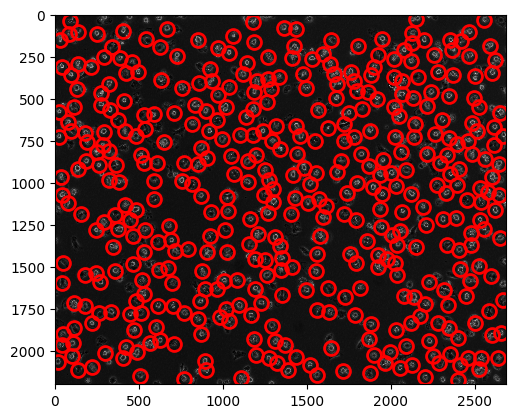

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

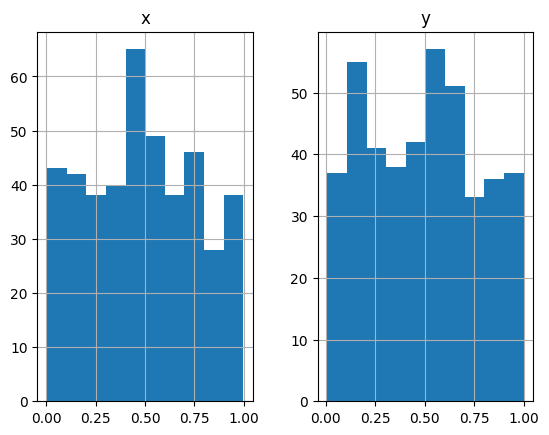

In [50]:
### Comment/Uncomment the below line to plot the segmented image
fig1 = tp.annotate(f, frames[0], plot_style={'markersize': 10})
fig1.figure.savefig('cellsIndentified.png')

##checking for subpixel accuracy
tp.subpx_bias(f)

In [51]:
### Step-4: Locate features in all frames
f = tp.batch(frames[:], thresh,minmass=min_mass);

Frame 28: 391 features


In [21]:
###Step-5,6: Link features into particle trajectories
# 68 is the no. of pixels moved and memory keeps track of disappeared particles and
# maintains their ID for up to some number of frames after their last appearance
t= tp.link(f,68)

Frame 28: 391 trajectories present.


In [22]:
###Step-7: Filter trajectories that exist in all the frames
t1 = tp.filter_stubs(t,dt ) #len(frames)
print('No. of tracks before filtering:', t['particle'].nunique())
print('No. of tracks after filtering:', t1['particle'].nunique())

No. of tracks before filtering: 2056
No. of tracks after filtering: 692


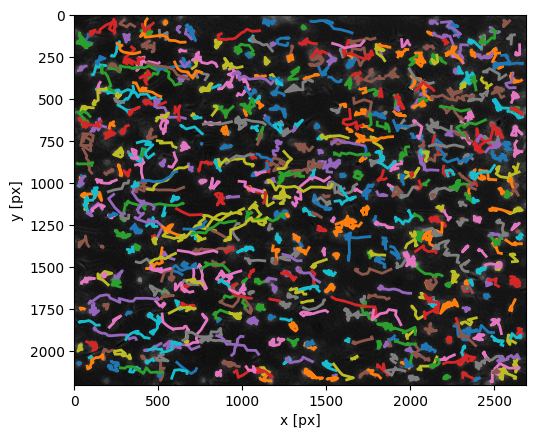

In [52]:
###Step-8: Results - Trajectories plotting
background = np.mean(frames, axis=0)

### Comment/Uncomment the below lines to plot the trajectories
plt.figure()
###superimpose will help to plot the trajectories on the background image
fig2 = tp.plot_traj(t1,superimpose=background,ax=plt.gca(),  plot_style={'linewidth': 2}); #label=True,
##plt.show()
fig2.figure.savefig('absolute_trajectories.png')

In [53]:
#### Below code is for reference. Commented as not used currently
#plt.rcParams['font.size'] = '8'
# plt.imshow(frames[0])
# plt.quiver(t1.x, t1.y, t1.x, -t1.y, pivot='middle', headwidth=4, headlength=6, color='red')

#plt.xlim(1000, 2000)
#plt.ylim(1000, 2000);

In [54]:
###Step-9: Results - Convert x,y to relative values
#the resolution in all images is 2.23 pix per micron, so 1 pixel = 1/2.23 microns
##generate relative x,y-values
all_rel_x = []
all_rel_y = []
for k in t1.particle.unique():
    curr_cell_x = t1.x[t1.particle == k]*(1/res)
    curr_cell_y = t1.y[t1.particle == k]*(1/res)
    rel_x = []; rel_y =[];
    for i in range(0 ,len(frames)-1): 
        if i < len(curr_cell_x):
            rel_x.append(curr_cell_x.iloc[i] - curr_cell_x.iloc[0])
            rel_y.append(curr_cell_y.iloc[i] - curr_cell_y.iloc[0])
    all_rel_x.append(rel_x) 
    all_rel_y.append(rel_y)

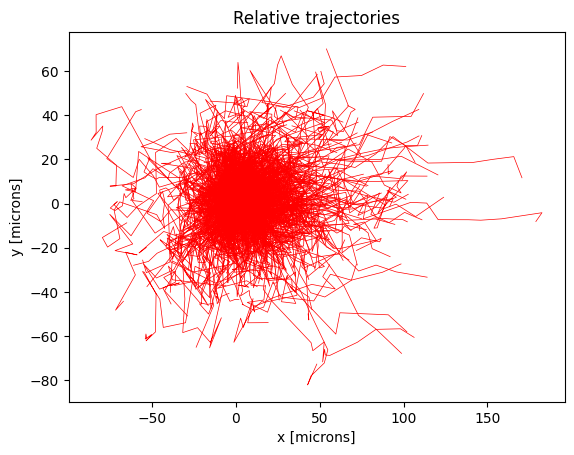

In [55]:
###Step-10: Results - Plot the relative x, y values
## Comment/Uncomment the below lines when needed to plot
plt.figure()
for j in range(0,  len(all_rel_x)):
    if(all(i <= 0 for i in all_rel_x[j])):
        plt.plot(all_rel_x[j],all_rel_y[j],'r-', linewidth=0.5)
    else:
        plt.plot(all_rel_x[j],all_rel_y[j],'r-' ,linewidth=0.5)
plt.xlabel(r'x [microns]')
plt.ylabel('y [microns]')
plt.title('Relative trajectories')
#plt.show()
plt.savefig('relative_trajectories.png')

In [56]:
##Displacement calculation speed 0.5< microns/micron. Range [0.3-0.7]
displacement =[]
for k in range(0, len(all_rel_x)):
    x0 = all_rel_x[k][0]
    xN = all_rel_x[k][len(all_rel_x[k])-1]
    y0 = all_rel_y[k][0]
    yN = all_rel_y[k][len(all_rel_x[k])-1]
    disp = np.sqrt((xN-x0)**2 + (yN-y0)**2)
    displacement.append(disp)

In [29]:
# ##Uncomment the below code to view the Displacement plot 
# plt.figure()
# plt.bar(range(0,  len(all_rel_x)),displacement)
# plt.xlabel(r'No. of cells')
# plt.ylabel('Cell Displacement[microns]')
# plt.title('Cell Displacement')
# plt.show()


In [30]:
# ##Uncomment the below code to view the Avg.Displacement plot 
# plt.boxplot(displacement)
# plt.xticks([1], ['Avg. displacement of the cells'])


In [59]:
# speed = sum(sqrt(xi^2+yi^2))/i*5
speed = []
for k in range(1, len(all_rel_x)):
    acc_dist = []
    for i in range(0, len(all_rel_x[k])):
        xi = all_rel_x[k][i]
        yi = all_rel_y[k][i]
        acc_dist.append(np.sqrt(xi**2 + yi**2))
    speed.append(np.sum(acc_dist)/(k*5))

In [60]:
# Changed directedness calculation using 6 frames ahead i.e. cos(theta) = Sum_i=0^n-1 (x_i+1 - xi / sqrt((x_i+1 - xi)^2 + (y_i+1 - yi)^2)) 
directedness_ch = []
for k in range(1, len(all_rel_x)):
    d_in_loop_ch = [0]
    dist_in_loop = []
    for i in range(0, len(all_rel_x[k])-dt): #first val is 0, hence the range starts from 1
        x_i = all_rel_x[k][i]
        y_i = all_rel_y[k][i]
        x_i1 = all_rel_x[k][i+dt]
        y_i1 = all_rel_y[k][i+dt]
        euc_dd = np.sqrt((x_i1 - x_i)**2 + (y_i1 - y_i)**2)
        d_in_loop_ch.append((x_i1 - x_i)/ euc_dd)
    directedness_ch.append(d_in_loop_ch)

In [61]:
##filtering the cells based on speed > 25 percentile data and last point of the directedness is not in the range of (-0.4,0.4)
filtered_dir = []; filtered_x =[]; filtered_y =[];
for j in range(0,len(all_rel_x)-1):
    if speed[j] >  np.percentile(speed, 25) and len(directedness_ch[j]) > 1:# and  (directedness_ch[j][len(directedness_ch[j])-1] > 0.4 or directedness_ch[j][len(directedness_ch[j])-1] < -0.4):
        filtered_dir.append(directedness_ch[j])
        filtered_x.append(all_rel_x[j])
        filtered_y.append(all_rel_y[j])
      

In [36]:
# #find avg directedness of all the cells at each point
# def Extract(lst,i):
#     return [item[i] for item in lst]

# #print(np.mean(Extract(directedness_ch,0)))

# mean_direct_ch = []
# for n in range(0,  len(filtered_dir[0])):
#     mean_direct_ch.append(np.mean(Extract(filtered_dir,n)))


# plt.figure()
# for j in range(0,  len(all_rel_x)):
#         plt.plot(range(0,  len(all_rel_x[k])-5),directedness_ch[j])
# plt.plot(range(0, 26),mean_direct_ch , color='k', linewidth=3)
# plt.xlabel(r'Time steps',fontSize="14")
# plt.ylabel('Cell Directedness',fontSize="14")
# plt.title('Cell Directedness',fontSize="16")
# plt.show()


Text(0.5, 1.0, 'Avg Directedness of the cells')

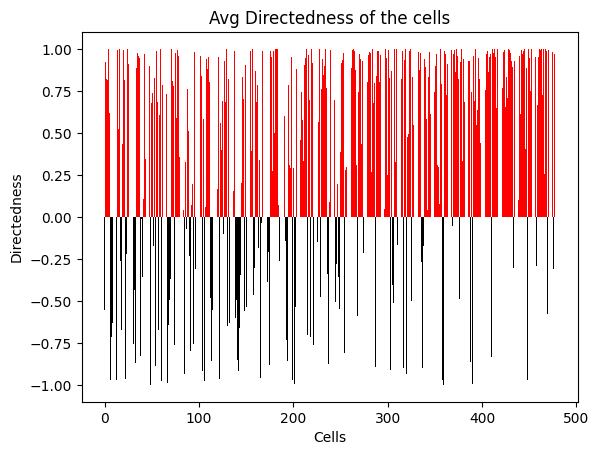

In [62]:
###Step-11: Results - Plot the Directedness change
avgD_ch = []
for m in range(0, len(filtered_dir)):
    #avg = np.sum(filtered_dir[m])/len(filtered_dir[m])
    #if avg > 0.2 or avg < -0.2:
    #avgD_ch.append(np.sum(filtered_dir[m])/len(filtered_dir[m]))
    avgD_ch.append(filtered_dir[m][len(filtered_dir[m])-1])

# Bar plot for directedness
fig3 = plt.figure()
for k in range(0, len(filtered_x)): 
    if (avgD_ch[k] < 0):
        colors = 'k'
    else:
        colors = 'r'
    plt.bar(k,avgD_ch[k], color = colors)   
plt.xlabel("Cells");
plt.ylabel("Directedness")
plt.title("Avg Directedness of the cells")


In [63]:
# ###Distance calculation

# distance = []
# for k in range(0, len(filtered_x)):
#     dist_in_loop = []
#     for i in range(0, len(filtered_x[k])-1): #first val is 0, hence the range starts from 1
#         x0 = filtered_x[k][i]
#         x1 = filtered_x[k][i+1]
#         y0 = filtered_y[k][i]
#         y1 = filtered_y[k][i+1]
#         dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
#         dist_in_loop.append(dist)
#     distance.append(dist_in_loop)
    
    
###Uncomment the below code to view the distance plot 
# plt.figure()
# for j in range(0,  len(all_rel_x)):
#         plt.plot(range(0,  len(all_rel_x[k])-1),distance[j])
# plt.xlabel(r'time in frames')
# plt.ylabel('Distance travelled by a cell[microns]')
# plt.title('Distance')
# plt.show()


In [64]:
###Recruitment index measure: (Cells to the anode - cells to the cathode)/total cells counted * 100
rec_index_lst = []          
for j in range(1,len(frames)-dt):   
    cells_anode = 0; cells_cathode = 0; total_cells = 0;  rec_index = 0;    
    for k in range(0, len(filtered_dir)): 
        if len(filtered_dir[k]) > j:
            total_cells +=1;
            if filtered_dir[k][j] > 0.01:
                cells_anode +=1;
            elif filtered_dir[k][j] < -0.01:
                cells_cathode +=1;
    rec_index = (cells_anode - cells_cathode)*100/total_cells 
    rec_index_lst.append(rec_index);


In [65]:
print('=================================================================================')
##Save all the values to export in a dataframe
d = {'CellNo': range(1,len(filtered_dir)+1), 'Directedness': filtered_dir}
df_final =  pd.DataFrame(data=d)

###Step-12: Export the x, y relative values and directedness to a csv
df_final.to_csv(r'Cell_directedness.csv',index=None)
print('Directedness values are written to the "Cell_directedness.csv" file successfully.')

rec = {'timestep': range(1, len(rec_index_lst)+1), 'RecruitmentIndex': rec_index_lst}
rec_index_vals = pd.DataFrame(data=rec)

rec_index_vals.to_csv(r'Recruitment_index_vals.csv',index=None)
print('Recruitment_index values are written to the "Recruitment_index_vals.csv" file successfully.')


with open('cellCounts.txt', 'w') as f:
    f.write("================= Cell counts for manual tracking verification =====================")
    f.write("\n\nNo. of cells tracked without any filters applied: %d" % t1['particle'].nunique())
    f.write("\nNo. of cells after applying the Speed filter > 25 percentile data: %d" % len(filtered_dir))
    
print('Cell counts are written to the "cellCounts.txt" file successfully.')
print('=================================================================================')


Directedness values are written to the "Cell_directedness.csv" file successfully.
Recruitment_index values are written to the "Recruitment_index_vals.csv" file successfully.
Cell counts are written to the "cellCounts.txt" file successfully.
